<a href="https://colab.research.google.com/github/Sooryakiran/CS6886_SysDL/blob/master/assignment_3/Submission/Step%204/step_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing FLOPS

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

### Test if drive is mounted

In [0]:
!cd 'drive/My Drive/SysDL/Assg 3/' && ls

mlruns	  pruning_mlflow  step_1.ipynb	step_2_pareto_plot.ipynb  step_4.ipynb
mlruns_2  pruning_models  step_2.ipynb	step_3.ipynb


In [0]:
class Flops:
    """
    A simple class to calculate the FLOPs of a network.

    """
    def __init__(self):
        """
        The class constructor

        """
        pass


    def addition(self, n):
        """
        Flops in a vector addiction of size n.

        @param n : Size of vector.
        @return  : Flops

        """

        return n-1
    

    def mul_elementwise(self, n):
        """
        Flops in a vector elementwise multiplication of size n.

        @param n : Size of vector.
        @return  : Flops
        
        """
        return n
    

    def activation(self, n, activation):
        """
        Flops in a vectorized activation operatino

        @param n          : Size of vector.
        @param activation : A string object denoting the type of activation function
        @return           : Flops
        
        """

        if activation == "relu":
            return n
        else:
            raise ValueError("Unknow activation or method not implimented")


    def vec_mat_mul(self, n, m):
        """
        Flops in a vector matrix multiplication

        @param n : Size of vector.
        @param m : Dimension 2 of matrix of dimentions [n x m]
        @return  : Flops
        
        """

        return (2*n-1)*m


    def dense(self, inputs, outputs, activation = "relu"):
        """
        Flops in a fully connected layer.

        @param inputs  : Size of input layer
        @param outputs : Size of current layer
        @return        : Flops
        
        """

        return self.vec_mat_mul(inputs, outputs) +\
               self.activation(outputs, "relu")
    

    def conv_output_size(self,\
                         input_size,\
                         kernel_size,\
                         filters,\
                         padding = 0,\
                         strides = 1):
        """
        Output dimension of a conv layer.

        @param input_size  : A list depicting input sizes in [N, C, H, W] format.
        @param kernel_size : Int, size of the conv. kernel.
        @param filters     : Number of conv. filters.
        @param padding     : Padding size in conv. if any.
        @param strides     : The stride value.
        @return            : Int, total number of elements in the output.

        """
        
        return filters * ((input_size[1] - kernel_size + 2*padding)/strides + 1) * \
                         ((input_size[2] - kernel_size + 2*padding)/strides + 1)

    def conv(self,\
             input_size,\
             kernel_size,\
             filters,\
             padding = 0,\
             strides = 1,\
             activation = "relu"):
        """
        Flops in a convolutional layer.

        @param input_size  : A list depicting input sizes in [N, C, H, W] format.
        @param kernel_size : Int, size of the conv. kernel.
        @param filters     : Number of conv. filters.
        @param padding     : Padding size in conv. if any.
        @param strides     : The stride value.
        @param activation  : A string object denoting the type of activation function.
        @return            : Int, total number of elements in the output.

        """
        single_output = self.mul_elementwise(input_size[0]*kernel_size**2) + \
                        self.addition(input_size[0]*kernel_size**2) + \
                        self.activation(1, activation)

        output_size   = self.conv_output_size(input_size,\
                                              kernel_size,\
                                              filters,\
                                              padding,\
                                              strides)
        
        return single_output * output_size
    

    def network(self, architecture, input_size):
        """
        Flops in a given network if passed with the given inputs.

        @param architecture : Python dict depicting the network architecture.
                              A sample format is given below:
                              {
                                  "name"   : ["type : conv/fc", arg1, arg2]
                                  "name_2" : ["conv", <kernel size>, <filters>]
                                  "name_3" : ["fc",   <no of neurons>]
                                  "conv_1" : ["conv", 3, 8],
                                  "conv_2" : ["conv", 3, 8],
                                  "fc_1"   : ["fc",   100],
                                  "fc_2"   : ["fc",   10]
                              }
        @param input_size   : A list depicting input sizes in [N, C, H, W] format.
        @return flops

        """
        
        layers             = list(architecture)
        flops              = 0
        current_input_size = input_size

        for layer in layers:
            if architecture[layer][0] == "conv":

                flops += self.conv(input_size  = current_input_size,\
                                   kernel_size = architecture[layer][1],\
                                   filters     = architecture[layer][2])
                
                current_input_size = [architecture[layer][2],\
                                      (current_input_size[1] - architecture[layer][1]) + 1,\
                                      (current_input_size[2] - architecture[layer][1]) + 1 ]

            elif architecture[layer][0] == "fc":
                if len(current_input_size) >= 1:
                    current_input_size = [np.prod(np.array(current_input_size))]

                flops += self.dense(inputs  = np.sum(np.array(current_input_size)),\
                                    outputs = architecture[layer][1])
                
                current_input_size = [architecture[layer][1]]
            else:
                raise ValueError("Unknown layer %s" %architecture[layer][0])
            if flops < 0:
                raise ValueError("Invalid input of size", input_size)
        return int(flops)

### Test with a sample architecture

In [0]:
architecture = {"conv_1" : ["conv", 3, 8],
                "conv_2" : ["conv", 3, 8],
                "fc_1"   : ["fc", 100],
                "fc_2"   : ["fc", 10]}
flops = Flops()
flops.network(architecture, input_size = [1, 28, 28])

1684496

### Pareto plots

In [0]:
import pandas as pd
import json 

!rm -r runs.csv
!wget https://raw.githubusercontent.com/Sooryakiran/CS6886_SysDL/master/assignment_3/Step%203/runs.csv 
df = pd.read_csv("runs.csv")

rm: cannot remove 'runs.csv': No such file or directory
--2020-05-07 16:40:41--  https://raw.githubusercontent.com/Sooryakiran/CS6886_SysDL/master/assignment_3/Step%203/runs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1777 (1.7K) [text/plain]
Saving to: ‘runs.csv’

runs.csv            100%[===================>]   1.74K  --.-KB/s    in 0s      

2020-05-07 16:40:42 (29.2 MB/s) - ‘runs.csv’ saved [1777/1777]



In [0]:
def string_to_dict(string_list):
    outputs = []
    for arch in string_list:
        arch = arch.replace("'", '"')
        res = json.loads(arch)
        outputs.append(res)
    return outputs

def arch_list_to_flop(arch_list, input_size = [1, 28, 28]):
    flop_list = []
    flops = Flops()
    for arch in arch_list:
        flop_list.append(flops.network(arch, input_size))
    return flop_list

In [0]:
accuracy_raw = np.asarray(df["Accuracy after training"])
arch_raw = string_to_dict(list(np.asarray(df["Channels/Neurons"])))
flop_raw = arch_list_to_flop(arch_raw)

### Plot

In [0]:
raw_data = np.asarray(flop_raw)
num_bins = 10
minimum  = np.min(raw_data)
maximum  = np.max(raw_data)
bin_size = (maximum-minimum)/num_bins
bins     = [0]*num_bins
label    = "FLOPs"
units    = "M"
acc_bin  = [0]*num_bins
labels   = []

for i in range(raw_data.shape[0]):
    bin_id = int((raw_data[i] - minimum)/bin_size)

    if bin_id == num_bins:
        bin_id -= 1

    bins[bin_id] += 1
    acc_bin[bin_id] = (acc_bin[bin_id]*(bins[bin_id] - 1) + accuracy_raw[i]*100)/bins[bin_id]

for i, item in enumerate(bins):
    idx       = bins.index(item)
    bins[idx] = maximum + 1
    min_val   = minimum + idx*bin_size

    if i == 0:
        min_val = 0

    max_val = min_val + bin_size
    current_label = label + " : %0.3f" %(min_val/1000000) + units + " - " + "%0.3f" %(max_val/1000000) + units
    labels.append(current_label)

acc_increase = []

for i in range(len(acc_bin)):
    if i == 0:
        acc_increase.append(acc_bin[i])
    else:
        acc_increase.append(acc_bin[i]-acc_bin[i-1])

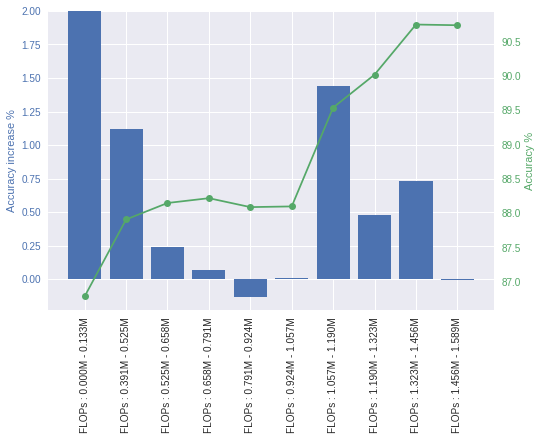

In [0]:
mpl.style.use('seaborn')
item_1  = acc_increase
fig, ax = plt.subplots()
ind     = np.arange(num_bins)
width   = 0.75
ax.bar(labels, item_1, color="C0")
plt.xticks(rotation = 90)
low  = np.min(np.asarray(item_1)) - 0.1
high = 2
plt.ylim(low, high)
ax.set_ylabel('Accuracy increase %')
ax.yaxis.label.set_color("C0")
ax2 = ax.twinx()
ax2.plot(labels, acc_bin, color="C1", marker="o", ms=7)
ax2.set_ylabel("Accuracy %")
ax2.yaxis.label.set_color("C1")
ax2.grid()
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")


In [0]:
flop_raw

[258332,
 260656,
 262980,
 265304,
 390872,
 516440,
 642008,
 767576,
 893144,
 1018712,
 1113824,
 1208936,
 1304048,
 1399160,
 1494272,
 1589384]